# Experiment 1: Acquiring time-domain IQ data following the flux curve and varying the clearing tone frequency and power

**Goal:**

Get `release_rates(clearing_tone_freq, clearing_tone_power)`

**Method:**

- Vary phi, find f(phi), set drive tone to f(phi)
- Vary clearing tone and clearing power and record I,Q data
- Run HMM analysis on the recorded data to get the rates




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from utils import *
from flux_fit import *

In [4]:
!python -m srsinst.dc205

## Setting up the Experiment


### Variables and Constants

In [5]:
project_name = "Andreev_Spectroscopy"
device_name = "L1A"
T_MXC = 26
T_Rad = 1.8
experiment_name = f"{device_name}_RUN0"

drive_path = r"G:\Shared drives\Quasiparticles_2"
data_path = set_project(r"{}\{}".format(drive_path, project_name), f"{experiment_name}")

# Constants
SPATH = data_path
FIG_PATH = os.path.join(SPATH, "Figures")
LOG_FILE = os.path.join(SPATH, f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log')
PATH_TO_EXE = r'C:/Users/LFL/lflPython/AlazarDrivers/CS_Average/x64/Release/ATS9371_CS_Average.exe'

# Ensure directories exist
os.makedirs(FIG_PATH, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, filemode='w', level=logging.INFO)


Project path set to: G:\Shared drives\Quasiparticles_2\Andreev_Spectroscopy\032625\L1A_RUN0


The best fit parameters from the flux fit curve - "G:\Shared drives\Labber\Data\2025\03\Data_03016\NBRL1A_flux_sweep_25mK.hdf5"

In [6]:
best_fit = {'w0': 5.781696425756177,
 'q0': 0.02019771764678007,
 'V_period': -53.166666666666664,
 'V_offset': -0.9999999999999964,
 'error': 0.00011195976902623324}

some test

In [7]:
print(voltage_to_flux_quanta(-24,best_fit))
print(flux_quanta_to_frequency(0.47, best_fit))
print(find_mapped_resonance(0.47, best_fit))
print(phi_to_voltage(0.47, best_fit, unit='mV'))

0.43260188087774304
5.711812537542725
5.711812537542725
-25.988333333333326


Setting up the phi's and getting the required voltage array with the detuning for the drive tone.

From Eli

"Start ~500 MHz above the resonator and go up to 18 GHz (bandwidth limit of SMA cables). Power, start ~ 5 dB below where you get resonance suppression, maybe go down to 20 dB lower"

In [ ]:
phi_low, phi_high = 0.3, 0.5
num_points = 30
phi_arr = np.linspace(phi_low, phi_high, num_points)
# reverse the phi_arr if negative phis
#phi_arr = phi_arr[::-1]
phi_arr

array([0.3       , 0.30689655, 0.3137931 , 0.32068966, 0.32758621,
       0.33448276, 0.34137931, 0.34827586, 0.35517241, 0.36206897,
       0.36896552, 0.37586207, 0.38275862, 0.38965517, 0.39655172,
       0.40344828, 0.41034483, 0.41724138, 0.42413793, 0.43103448,
       0.43793103, 0.44482759, 0.45172414, 0.45862069, 0.46551724,
       0.47241379, 0.47931034, 0.4862069 , 0.49310345, 0.5       ])

In [9]:
v_arr, f_arr = from_flux_fit(phi_arr, best_fit) # mV, GHz

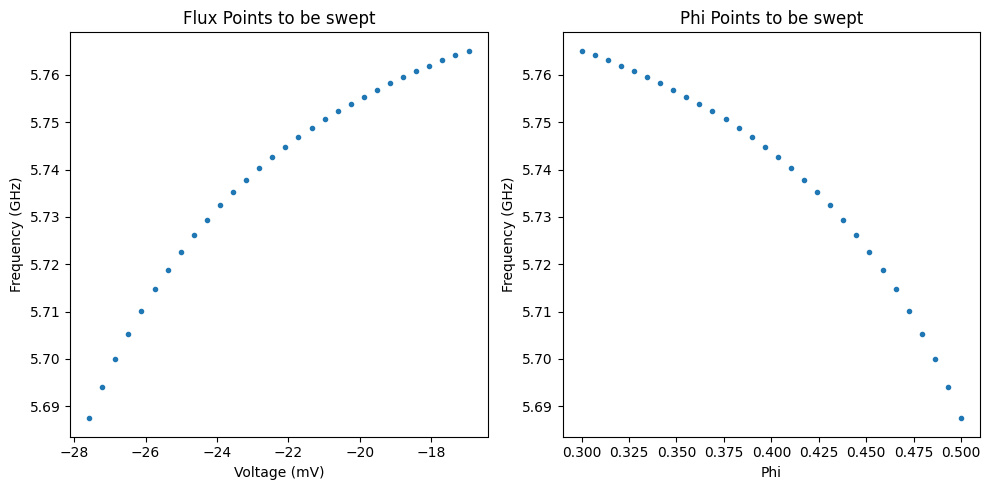

In [10]:
plot_sweep_points(v_arr, f_arr, phi_arr)

### Instrument Setup

In [11]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25
Successfully connected to SignalCore SC5511A Signal Generator_1000334C
Successfully connected to Vaunix Lab Brick Digital Attenuator


The labber instrument server config is saved as a hdf5 file in this repository. Instantiating the instruments we need now.

In [12]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']
TWPA_PUMP = instruments['Rohde&Schwarz RF Source']

initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP)

In [13]:
vs.check_id()

('DC205', 's/n20500691', 'ver1.80')

In [14]:
# VNA + LO Drive
span = 10e6 # Hz
electrical_delay = 82.584e-9 # s
vna_power = 5
vna_avg = 20
f_d_power = 16

# Clearing
f_low, f_high = 5, 17
f_step = 1
f_clearing_arr = np.arange(f_low, f_high+f_step, f_step)

P_low, P_high = -10, 17
P_step = 1
P_clearing_arr = np.arange(P_low, P_high+P_step, P_step)

In [15]:
num_traces=1
acquisitionLength_sec=5
origRateMHz=300
sampleRateMHz=10
averageTimeCycle=0
lowerBound=14 # dB for DA attenuator
upperBound=30 # dB for DA attenuator

## The driver code

In [16]:
# Create a log file for the VNA data
lfVNA = Labber.createLogFile_ForData(f'{device_name}_flux_sweep_RUN0',
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Phi','values':phi_arr,'unit':'flux quanta'}])

initialize_logging(lfVNA, SPATH, PATH_TO_EXE, FIG_PATH, device_name)

We have checked in advance that the TWPA pump with the following configuration gives us +20 dB in the entire frequency range of interest.

In [17]:
set_TWPA_pump(f=6.04, power=27)

In [ ]:
start_time = time.time()

for phi in phi_arr:
    print("="*50)
    voltage = phi_to_voltage(phi, best_fit, unit='V')
    print(f"phi: {phi:.6f}, voltage: {voltage:.6f} V")
    set_flux_bias_srs(voltage, step = 5e-5)
    
    turn_off_LO()
    turn_off_clearing()
    f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, electrical_delay, show_plot=False)
    set_LO_tone(f_drive, f_d_power)
    print(f"f_phi: {f_phi*1e-9:.6f} GHz, f_drive: {f_drive*1e-9:.6f} GHz") 

    for f_clearing in f_clearing_arr:
        for P_clearing in P_clearing_arr:
            print(f"f_clearing: {f_clearing:.6f} GHz, P_clearing: {P_clearing:.6f} dBm")
            set_clearing_tone(f_clearing, P_clearing)
            logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} while driving at {f_drive:.6f} GHz')
            savefile = acquire_IQ_data(phi, f_clearing, P_clearing, num_traces, acquisitionLength_sec, origRateMHz, sampleRateMHz, averageTimeCycle, lowerBound, upperBound)
            write_metadata(savefile, acquisitionLength_sec, origRateMHz, f_drive, voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)
            sleep(0.5)

    logging.info(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
    print(f'Finished loop for phi = {phi:.3f} in {time.time() - start_time:.2f} seconds')
    current_idx = np.where(phi_arr == phi)[0][0]  # Get the index of current phi
    remaining_time = (time.time() - start_time) * (len(phi_arr) - current_idx - 1) / (current_idx + 1)
    print(f'\n\nEstimated remaining time: {remaining_time:.2f} seconds')
    logging.info(f'Estimated remaining time: {remaining_time:.2f} seconds')

# Close the log file
print(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')
logging.info(f'Finished flux sweep for {device_name} in {time.time() - start_time:.2f} seconds')

phi: 0.300000, voltage: -0.016950 V
Output status: on
Setting FFL bias to -16.949999999999996 mV
Starting voltage: 0.0082 V
f_guess: 5.765075900361882 GHz from the fitted Flux Curve
Saving figure to: G:\Shared drives\Quasiparticles_2\Andreev_Spectroscopy\032625\L1A_RUN0\Figures\vna_fit_0.3000.png
f_phi: 5.760226 GHz, f_drive: 5.760226 GHz
f_clearing: 5.000000 GHz, P_clearing: -10.000000 dBm


 67%|██████▋   | 6/9 [01:04<00:32, 10.72s/it]


KeyboardInterrupt: 